In [24]:
path = []
# !pip install plotly==4.14.3

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
  Using cached https://mirrors.aliyun.com/pypi/packages/1f/f6/bd3c17c8003b6641df1228e80e1acac97ed8402635e46c2571f8e1ef63af/plotly-4.14.3-py2.py3-none-any.whl (13.2 MB)


'4.14.3'

In [2]:
import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        path.append(os.path.join(dirname, filename))

In [30]:
import pandas as pd
import numpy as np
import re
import sklearn
# import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

from sklearn.model_selection import KFold

In [4]:
train = pd.read_csv("./data/train.csv")
test  = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/gender_submission.csv")
combine = [train, test]
full_data = [train, test]

In [5]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand = False)

train['name_len'] = train.Name.apply(len)
test['name_len'] = test.Name.apply(len)
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


In [8]:
print('Train columns with null values:\n', train.isnull().sum())

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Title            0
name_len         0
Has_Cabin        0
dtype: int64


In [7]:
for dataset in combine:
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)


In [12]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

/Users/fyenne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [15]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [16]:
#delete the cabin feature/column and others previously stated to exclude in train dataset
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

print(train.isnull().sum())
print("-"*10)
print(test.isnull().sum())


Survived      0
Pclass        0
Sex           0
Age           0
Parch         0
Fare          0
Embarked      0
Title         0
name_len      0
Has_Cabin     0
FamilySize    0
IsAlone       0
dtype: int64
----------
Pclass        0
Sex           0
Age           0
Parch         0
Fare          0
Embarked      0
Title         0
name_len      0
Has_Cabin     0
FamilySize    0
IsAlone       0
dtype: int64


In [17]:
train.head(3)


,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Title,name_len,Has_Cabin,FamilySize,IsAlone
0,0,3,1,1,0,0,0,1,23,0,2,0
1,1,1,0,2,0,3,1,3,51,1,2,0
2,1,3,0,1,0,1,0,2,22,0,1,1


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

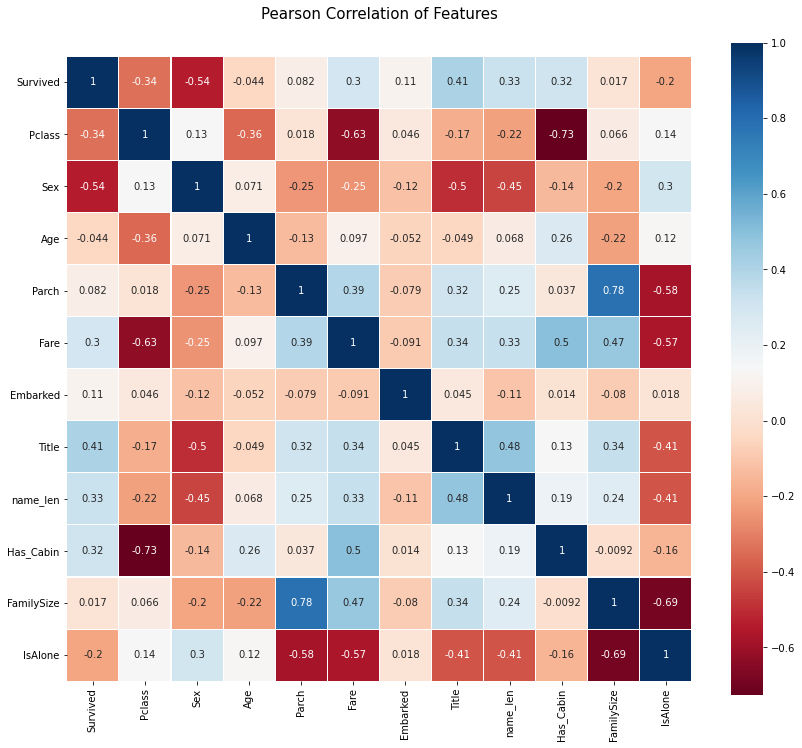

In [21]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

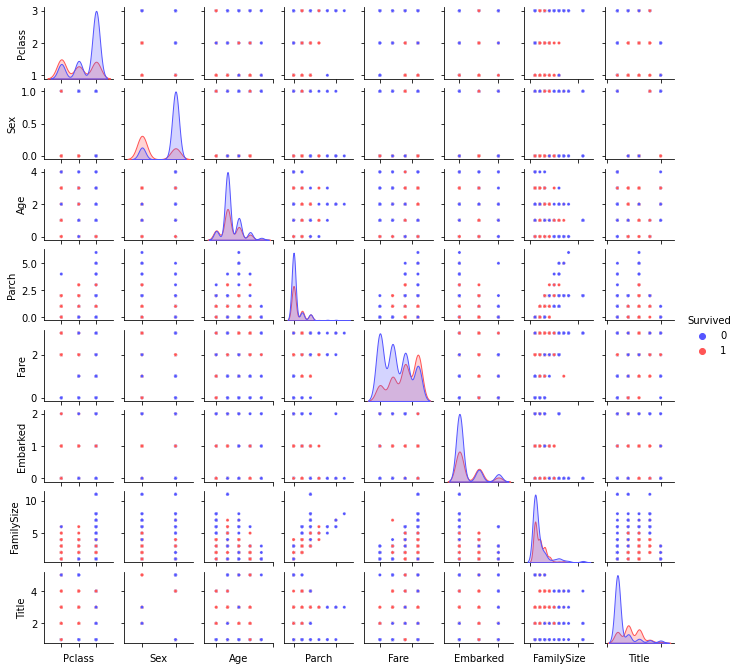

In [31]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']],
                 hue='Survived',
                 palette = 'seismic', size=1.2,
                 diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [34]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_splits= NFOLDS, random_state=SEED)

In [35]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self,x,y):
        return self.clf.fit(x,y)

    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)


In [44]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

In [ ]:
y_train = train.pop("Survived")

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [46]:
logreg = LogisticRegression()
logreg.fit(train, y_train)
Y_pred = logreg.predict(test)
acc_log = round(logreg.score(train, y_train) * 100, 2)
acc_log

81.82

In [47]:

train

,Pclass,Sex,Age,Parch,Fare,Embarked,Title,name_len,Has_Cabin,FamilySize,IsAlone
0,3,1,1,0,0,0,1,23,0,2,0
1,1,0,2,0,3,1,3,51,1,2,0
2,3,0,1,0,1,0,2,22,0,1,1
3,1,0,2,0,3,0,3,44,1,2,0
4,3,1,2,0,1,0,1,24,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,1,0,1,0,5,21,0,1,1
887,1,0,1,0,2,0,2,28,1,1,1
888,3,0,1,2,2,0,2,40,0,4,0
889,1,1,1,0,2,1,1,21,1,1,1
